## Load in vivo data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp

invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = 'cell_inference/resources/invivo'
DATA_PATH = os.path.join(INVIVO_PATH, invivo_name + '.h5')
LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics

save_lfp = False
save_stats = False

In [2]:
with h5py.File(DATA_PATH,'r') as hf:
    elec_pos = hf['coord'][()]
    lfp = 1e-3 * hf['data'][()].transpose((0,2,1)) # (samples x channels x time) -> (samples x time x channels), uV -> mV
    if 'layer' in hf:
        layer_type = {i[0]: name for name, i in hf['layer'].attrs.items()}
        layer = np.array([layer_type[i] for i in hf['layer']])
    else:
        layer = np.full(lfp.shape[0], 'N/A')

## Process LFP

In [3]:
if save_lfp or save_stats:
    pad_spike_window = False
    bad_cases = tuple(range(-1,3)) if pad_spike_window else tuple(range(3))

    bad_indices = {bad: [] for bad in bad_cases}
    lfp_list = []
    coord = []
    ycenter = []
    summ_stats = []

    for i in tqdm(range(lfp.shape[0])):
        bad, g_lfp, _, g_coords, y_c, _, ss = process_lfp(lfp[i], coord=elec_pos, dt=None,
                                                   calc_summ_stats=save_stats, additional_stats=2, err_msg=True)
        bad_indices[bad].append(i)
        if bad<=0:
            lfp_list.append(g_lfp)
            coord.append(g_coords)
            ycenter.append(y_c)
            if save_stats:
                summ_stats.append(ss)

    t = params.DT * np.arange(params.WINDOW_SIZE)
    windowed_lfp = np.stack(lfp_list, axis=0)  # (samples x time window x channels)
    coord = np.stack(coord, axis=0)
    ycenter = np.array(ycenter)
    summ_stats = np.array(summ_stats)

    bad_idx = np.array([i for bad, indices in bad_indices.items() if bad>0 for i in indices])
    good_indices = np.sort([i for bad, indices in bad_indices.items() if bad<=0 for i in indices])
    print('%d good samples out of %d samples.' % (good_indices.size, lfp.shape[0]))
    for bad, indices in bad_indices.items():
        print('Bad case %d bad: %d samples.' % (bad, len(indices)))

## Save results

In [4]:
if save_lfp:
    np.savez(LFP_PATH, t=t, x=windowed_lfp, coord=coord, yc=ycenter, layer=layer,
             bad_indices=bad_indices, good_indices=good_indices)
if save_stats:
    np.savez(STATS_PATH, x=summ_stats, yc=ycenter, layer=layer[good_indices])

## Check LFP amplitude decay

In [5]:
summ_stats = np.load(STATS_PATH)['x']
layer = np.load(STATS_PATH)['layer']

dy = np.diff(params.ELECTRODE_GRID[1][:2])[0]
decay_stats = dy * summ_stats[:, -8:]
decay_name = np.array(['tr_lambda_l', 'tr_lambda_r', 'tr_slope_l', 'tr_slope_r',
                       'pk_lambda_l', 'pk_lambda_r', 'pk_slope_l', 'pk_slope_r'])
decay_dict = {name: decay_stats[:, i] for i, name in enumerate(decay_name)}
df_decay = pd.DataFrame(decay_dict)
df_decay['layer'] = layer
layer_idx = {L: np.nonzero(layer==L)[0] for L in np.unique(layer)}
sort_idx = np.argsort(np.array([idx.size for idx in layer_idx.values()]))[::-1]
layer_idx = dict(zip(np.asarray(list(layer_idx.keys()))[sort_idx], np.asarray(list(layer_idx.values()), dtype=object)[sort_idx]))

#### Distributions of decay length constant

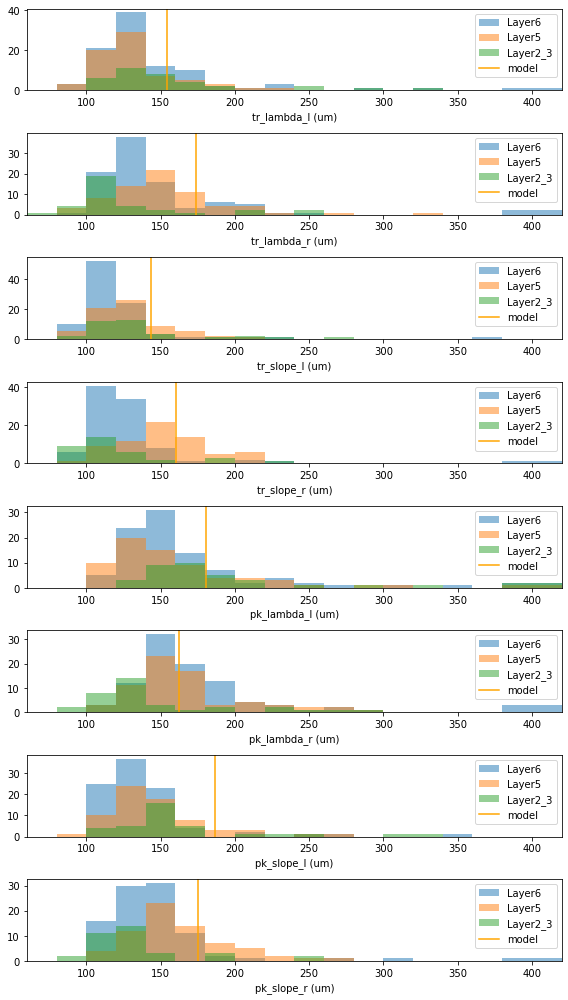

In [6]:
%matplotlib inline

bin_max = 20
bin_min = int(np.floor(np.amin(decay_stats) / dy))
bins = np.append(dy * np.arange(bin_min, bin_max), np.amax(decay_stats))

# Baseline: Long trunk = 845 um, R = 1.27 um, g_Ca = 0, h = 1
# example_decay = '[159.85236571 259.85499107 152.29735141 220.63571681 153.11734412 186.71465362 177.98086139 198.61188113]'

# high g_Ca = 3.5 x g_leak
# example_decay = '[160.89414206 269.64089959 154.43840114 216.58320007 158.76555772 199.95192193 180.63385505 213.70307144]'

# thin mid trunk R = 0.8 um
example_decay = '[154.06072634 173.66256666 143.81147155 160.64192185 180.54980095 162.69670286 186.86432643 175.3706075]'

# Short trunk = 5 um
# example_decay = '[156.65895355 217.65670653 147.75082179 188.28481118 158.25794157 173.04326338 174.13922093 183.68921334]'

# Orientation h = 0.9
# example_decay = '[161.28460489 156.16263227 165.71461537 149.07170661 127.86058627 306.0548489 143.15319122 230.22268954]'

example_decay = np.array(eval(example_decay.replace(' ', ','))).ravel()

plt.figure(figsize=(8, 14))
for i, name in enumerate(decay_name):
    plt.subplot(decay_name.size, 1, i + 1)
    for L, idx in layer_idx.items():
        plt.hist(decay_dict[name][idx], bins=bins, label=L, alpha=0.5)
    plt.axvline(x=example_decay[i], color='orange', label='model')
    plt.xlim([bins[0], bins[-2] + bins[2] - bins[0]])
    plt.xlabel(name + ' (um)')
    plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# sort by selected feature
df_decay = df_decay.sort_values('tr_lambda_r')
display(df_decay)

,tr_lambda_l,tr_lambda_r,tr_slope_l,tr_slope_r,pk_lambda_l,pk_lambda_r,pk_slope_l,pk_slope_r,layer
123,115.048215,79.304041,95.191543,86.538602,140.466583,88.638922,112.533706,96.163917,Layer2_3
53,114.361176,83.534932,97.525074,98.908084,131.006129,100.332236,110.422753,114.024932,Layer5
38,119.497922,84.662514,92.363354,90.327236,150.929901,104.400150,109.679430,114.230496,Layer6
193,145.192601,86.802637,125.377038,96.327370,168.464315,94.281033,150.263176,103.136054,Layer2_3
192,114.098100,89.460555,128.736198,98.815745,145.677998,101.266285,167.711818,110.044055,Layer2_3
...,...,...,...,...,...,...,...,...,...
118,325.291081,251.486782,272.932578,224.299403,420.125710,260.601558,314.893541,247.621491,Layer2_3
182,157.237932,273.718726,175.955420,203.018122,250.417506,263.187126,186.515211,264.329175,Layer5
103,193.594977,324.672834,207.118440,210.453273,393.670787,282.828650,257.591244,223.112517,Layer5
133,336.749765,649.419523,370.972744,423.651863,434.203982,549.629547,358.517614,397.868193,Layer6


#### Plot LFP of selected in vivo cell and check decay of LFP magnitude

In [8]:
select_id = 103

good_indices = np.load(LFP_PATH)['good_indices']
t = np.load(LFP_PATH)['t']
lfp = np.load(LFP_PATH)['x'][good_indices[select_id]]
coords = np.load(LFP_PATH)['coord'][good_indices[select_id]]
print(layer[select_id])

Layer5


In [9]:
import cell_inference.utils.feature_extractors.SummaryStats2D as ss

t_t, t_p, troughs, peaks = ss.get_tr_pk(1000 * lfp)
grid_shape = (ss.GRID_SHAPE[0], int(lfp.shape[1]/ss.GRID_SHAPE[0]))
y_troughs = ss.get_max_val_y(troughs, grid_shape)
y_peaks = ss.get_max_val_y(peaks, grid_shape)
lambda_troughs = ss.get_decay(y_troughs)
lambda_peaks = ss.get_decay(y_peaks)

np.set_printoptions(suppress=True)
print('Length constant (um) of troughs / peaks: \n  by lambda (left, right), by slope (left, right)')
print(dy * np.array([lambda_troughs, lambda_peaks]))

Length constant (um) of troughs / peaks: 
  by lambda (left, right), by slope (left, right)
[[193.59497664 324.67283369 207.11844007 210.45327301]
 [393.67078709 282.8286503  257.59124412 223.11251673]]


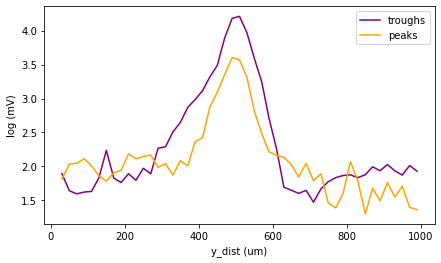

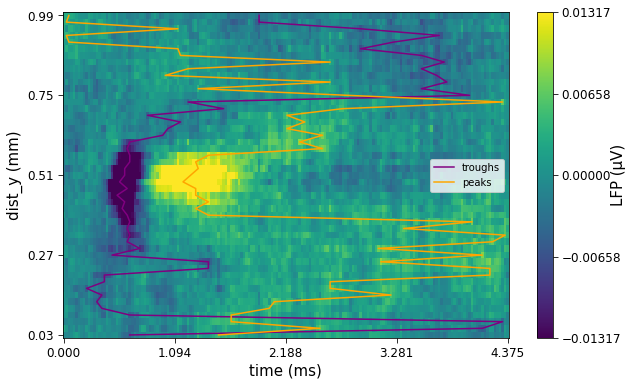

In [10]:
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
%matplotlib inline

ix = 1
fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5

x_dist = np.unique(coords[:, 0])
e_idx = coords[:, 0]==x_dist[ix]

plt.figure(figsize=(7,4))
plt.plot(coords[e_idx, 1], np.log(y_troughs), color='purple', label='troughs')
plt.plot(coords[e_idx, 1], np.log(y_peaks), color='orange', label='peaks')
plt.xlabel('y_dist (um)')
plt.ylabel('log (mV)')
plt.legend()

plt.figure(figsize=(10,6))
_ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto', axes=plt.gca())
plt.plot(t[t_t[e_idx]], coords[e_idx, 1]/1000, color='purple', label='troughs')
plt.plot(t[t_p[e_idx]], coords[e_idx, 1]/1000, color='orange', label='peaks')
plt.legend()
plt.show()